In [2]:
import mne
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader,Subset
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, auc, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import json
import time
import onnx
import onnxscript
import os

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

mne.set_log_level('ERROR')
mne.cuda.init_cuda(verbose=True)

CUDA not enabled in config, skipping initialization


/tmp/ipykernel_4743/3244034687.py:27: RuntimeWarning: The MNE-Python config file (/home/mattbls/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  mne.cuda.init_cuda(verbose=True)


In [6]:
print(device)

cuda


In [5]:
CHB_files1 = {
    'CHB-MIT/CHB_Database/chb01/chb01_01.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_02.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_03.edf': [(0, 2396, 'interictal'), (2396, 2996, 'preictal'), (2996, 3036, 'ictal'), (3036, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_04.edf': [(0, 867, 'interictal'), (867, 1467, 'preictal'), (1467, 1494, 'ictal'), (1494, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_05.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_06.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_07.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_08.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_09.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_10.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_11.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_12.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_13.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_14.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_15.edf': [(0, 1132, 'interictal'), (1132, 1732, 'preictal'), (1732, 1772, 'ictal'), (1772, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_16.edf': [(0, 415, 'interictal'), (415, 1015, 'preictal'), (1015, 1066, 'ictal'), (1066, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_17.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_18.edf': [(0, 1120, 'interictal'), (1120, 1720, 'preictal'), (1720, 1810, 'ictal'), (1810, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_19.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_20.edf': [(0, 2663, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_21.edf': [(0, 327, 'preictal'), (327, 420, 'ictal'), (420, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_22.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_23.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_24.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_25.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_26.edf': [(0, 1262, 'interictal'), (1262, 1862, 'preictal'), (1862, 1963, 'ictal'), (1963, 2325, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_27.edf': [(0, 600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_29.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_30.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_31.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_32.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_33.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_34.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_36.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_37.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_38.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_39.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_40.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_41.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_42.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_43.edf': [(0, 3600, 'interictal')],
    'CHB-MIT/CHB_Database/chb01/chb01_46.edf': [(0, 3600, 'interictal')]
    }

In [6]:
# Used to read our json file of each dictionary mapped to it's file name
def read_dict_from_json_file(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

In [7]:
class CHBData(Dataset):
    def __init__(self, segment_dict, mean, std):
        self.segment_dict = segment_dict
        # Mapping label names to integers
        self.label_to_int = {'interictal': 0, 'preictal': 1, 'ictal': 2}
        self.mean = torch.tensor(mean, dtype = torch.float32)
        self.std = torch.tensor(std, dtype = torch.float32)

    def __len__(self):
        return len(self.segment_dict)

    def __getitem__(self, index,):
        
        segment = torch.load(f'CHB-MIT/Segments/chb02/{index}-chb02.pt')
        #uncomment this when we get our mean and std  values
        #segment = (segment - self.mean) / (self.std)
        segment.unsqueeze(0)

        # Retrieve the label and map it to an integer
        label_name = self.segment_dict[f'CHB-MIT/Segments/chb02/{index}-chb02.pt']
        label = self.label_to_int[label_name]
        segment = segment.float().to(device)
        return segment, label

In [9]:
segment_dict = read_dict_from_json_file('CHB-MIT/segment_dict2.json')

In [10]:
#calculate mean and std for Z score normalization, run this after defining dataset and then get parameters to create new dataset
def calculate_mean_std(dataset):
    sum_ = 0
    sum_sq = 0
    total_samples = 0

    for i in range(len(dataset)):
        segment, _ = dataset[i]  # Assuming dataset[i] returns (segment_tensor, label)
        # Flatten the segment to calculate global mean and std
        segment_flat = segment.view(segment.size(0), -1)
        sum_ += torch.mean(segment_flat, dim=1)
        sum_sq += torch.mean(segment_flat ** 2, dim=1)
        total_samples += 1

    mean = sum_ / total_samples
    std = (sum_sq / total_samples - mean ** 2) ** 0.5
    return mean, std


 #get values for mean and std and use to compute z score normlaization when you redfine dataset

In [13]:
segment_dict = read_dict_from_json_file('CHB-MIT/segment_dict1.json')

In [9]:
num_workers = 0
full_dataset = CHBData(segment_dict)

# Split the dataset into train and test sets
train_indices, test_indices = train_test_split(range(len(full_dataset)), test_size=0.3, random_state=42)

#  split the test set into validation and actual test sets
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=42)

# dataloaders for training, validation, and test
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Instantiate dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers, drop_last=True)
#training_dataset = CHBData(segment_dict)
#mean, std = calculate_mean_std(training_dataset)

In [11]:
# Our calculated mean and standard deviation
mean = 1.9299e-12
std = 1.699e-05

In [15]:
print(mean)
print(std)

1.9299e-12
1.699e-05


In [12]:
num_workers = 0
full_dataset = CHBData(segment_dict, mean, std)

# Split the dataset into train and test sets
train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=0.3, random_state=42)

#  split the test set into validation and actual test sets


# dataloaders for training, validation, and test
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# Instantiate dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_workers, drop_last=True)


In [ ]:
class SeizureSense(nn.Module):
    
    def __init__(self):
        super(SeizureSense,self).__init__()
        
        #Block 1
        #should be taking in an input of 23x512
        #first layer temporal filters
        self.conv1=nn.Conv2d(1,8,(1,128),stride=1,padding=0)
        self.batchnorm1 = nn.BatchNorm2d(8, False)
        
        #spatial layer(depthwise layer)
        self.conv2=nn.Conv2d(8,32,(23,1))
        self.batchnorm2 = nn.BatchNorm2d(32, False)
        self.avgpool1 = nn.AvgPool2d((1,2))
        #apply dropout here in forward
        
        
        #Block 2
        #sepereable convolutional 2d
        self.conv3=nn.Conv2d(32,32,(1,16),stride=1)
        self.batchnorm3 = nn.BatchNorm2d(32,False) #CHECK THIS!
        self.avgpool2 = nn.AvgPool2d((1,16))
        self.adaptivepool = nn.AdaptiveAvgPool2d((96))


        
        #Block 3
        
        self.fc1= nn.Linear(96, 30)
        self.fc2=nn.Linear(30,3)

        #apply dropout here in forward
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.elu(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = F.elu(x)
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.avgpool1(x)
        
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.avgpool2(x)
        x = self.adaptivepool(x)
        x = x.view(x.size(0), -1)  # Adjust this based on the output size of adaptive pooling
        x = F.elu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Use torch.sigmoid instead of F.sigmoid (deprecated)
        return x

In [14]:
model=SeizureSense()
model.to(device)

SeizureSense(
  (conv1): Conv2d(1, 8, kernel_size=(1, 128), stride=(1, 1))
  (batchnorm1): BatchNorm2d(8, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 32, kernel_size=(23, 1), stride=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool1): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
  (conv3): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 1))
  (batchnorm3): BatchNorm2d(32, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool2): AvgPool2d(kernel_size=(1, 16), stride=(1, 16), padding=0)
  (fc1): Linear(in_features=96, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=3, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [15]:
#maps back the labels to words
def decode_predictions(predictions):
    label_names = ['interictal', 'preictal', 'ictal']
    _, predicted_labels = torch.max(predictions, 1)
    return [label_names[label] for label in predicted_labels]

In [28]:
optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")

Optimal threshold: 0.08260418474674225


In [16]:
optimal_threshold = 0.082604

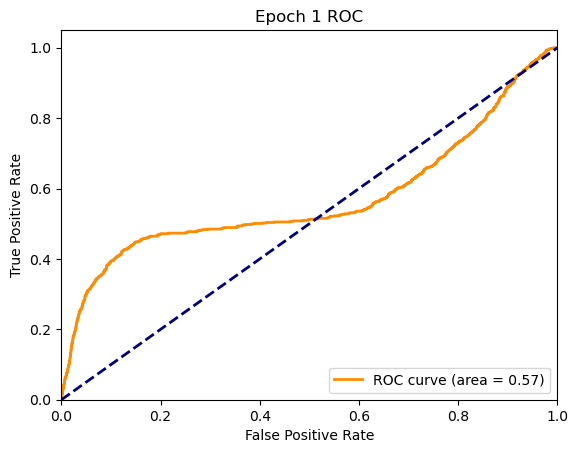

Epoch 1/5 - Loss: 0.1048, Accuracy: 0.9766, Recall: 0.0275, AUROC: 0.5691


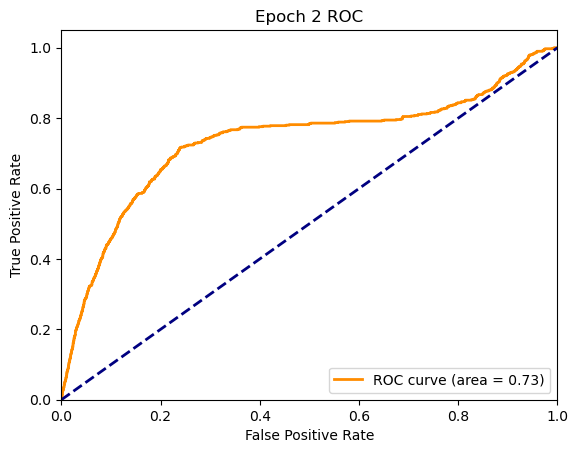

Epoch 2/5 - Loss: 0.0829, Accuracy: 0.9787, Recall: 0.0029, AUROC: 0.7339


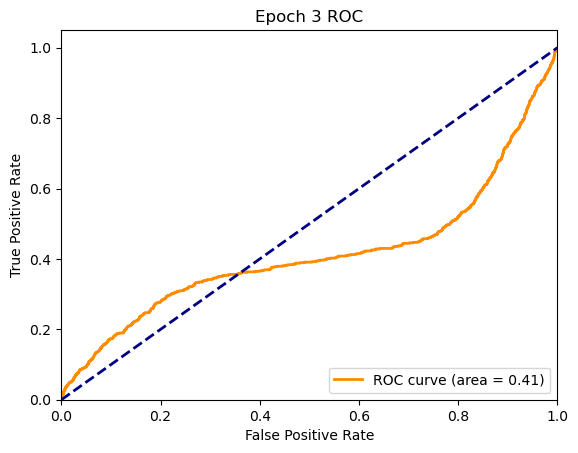

Epoch 3/5 - Loss: 0.0756, Accuracy: 0.9787, Recall: 0.0000, AUROC: 0.4142


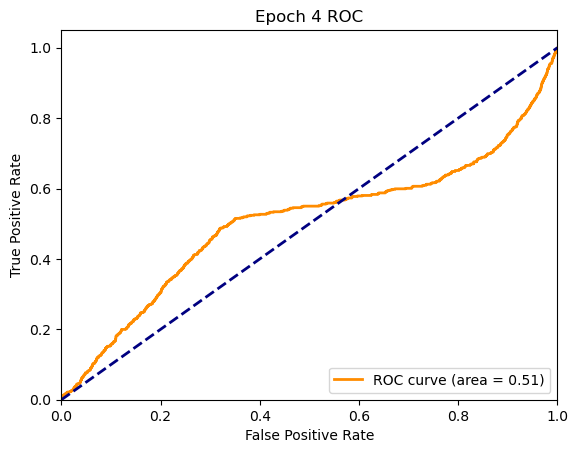

Epoch 4/5 - Loss: 0.0715, Accuracy: 0.9774, Recall: 0.0101, AUROC: 0.5055


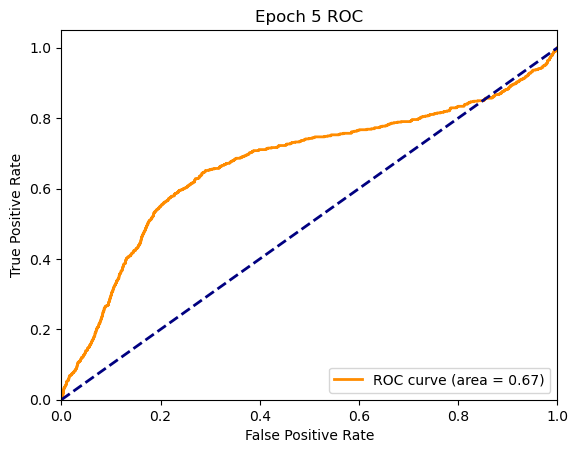

Epoch 5/5 - Loss: 0.0678, Accuracy: 0.9787, Recall: 0.0000, AUROC: 0.6718


In [17]:
# Assuming model, train_loader, and val_loader are already defined
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5
num_classes = 3
losses = []

for epoch in range(num_epochs):
    start_time = time.time()  # Start timing
    
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.float().to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
    # Validation Phase
    model.eval()
    val_labels = []
    val_probabilities = []  # Store probabilities for AUROC calculation
    val_predictions = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.float().to(device), labels.to(device)
            logits = model(inputs)
            outputs = F.softmax(logits, dim=1)            
            
            positive_class_probabilities = outputs[:, 1]
            predictions = (positive_class_probabilities.cpu().numpy() > optimal_threshold).astype(int)
            
            val_labels.extend(labels.cpu().numpy())  # Convert to numpy array
            val_predictions.extend(predictions)
            val_probabilities.extend(outputs.cpu().numpy())  # Convert to numpy array
    
    # Calculate metrics
    accuracy = accuracy_score(val_labels, val_predictions)
    recall = recall_score(val_labels,val_predictions, average=None)[1]
    # Calculate AUROC
    # For multi-class AUROC, we need to binarize the labels
    val_labels_binarized = label_binarize(val_labels, classes=range(num_classes))[:,1]
    val_probabilities_array = np.array(val_probabilities)
    auroc = roc_auc_score(val_labels_binarized, val_probabilities_array[:,1])
    
    # Calculate the ROC curve points
    fpr, tpr, thresholds = roc_curve(val_labels_binarized, val_probabilities_array[:,1])
    roc_auc = auc(fpr, tpr)  # Recalculate AUROC using AUC function for consistency in plotting

    plt.figure()
    lw = 2  # Line width
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Epoch {epoch+1} ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {np.mean(losses):.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, AUROC: {auroc:.4f}')

    # Reset losses for next epoch
    losses = []

In [31]:
torch.save(model.state_dict(), 'SeizureSenseStateDict.pth')